# Linear Regression on Advanced Housing Price Dataset 

Source of data comes from: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

pd.set_option('display.max_colwidth',-1)

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

pd.set_option('display.max_colwidth',-1)

In [3]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))

In [4]:

all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


# 1. Handling Missing Values
Visualize the missing values using heatmap


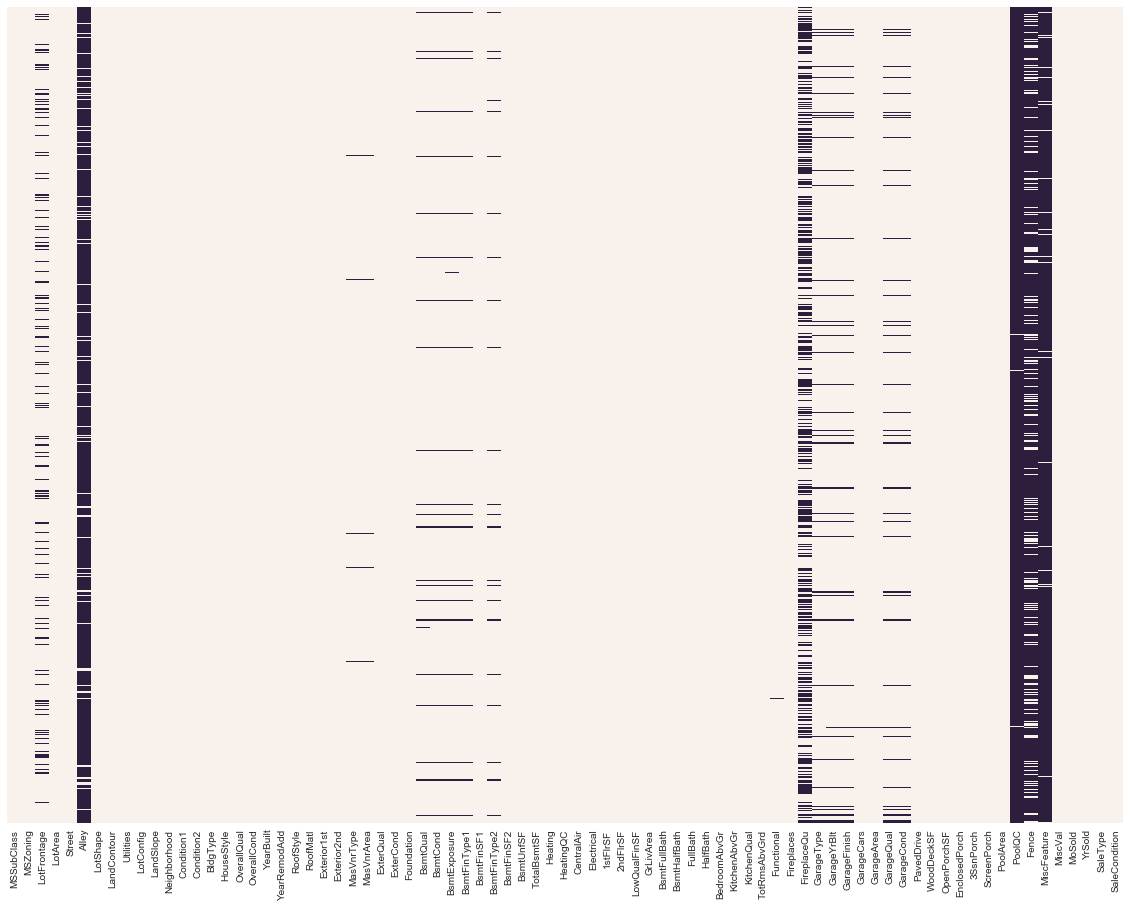

In [5]:
plt.figure(figsize=(20,15))
sns.heatmap(all_data.isnull(),yticklabels= False, cbar= False)


It seems that we will have to drop: 'LotFrontage', 'Alley','FireplaceQu','PoolQC','Fence', 'MiscFeature' 
as the missing value is more than 30% of the observations

In [43]:
#train.columns 

### Drop all the columns with too many NA values 

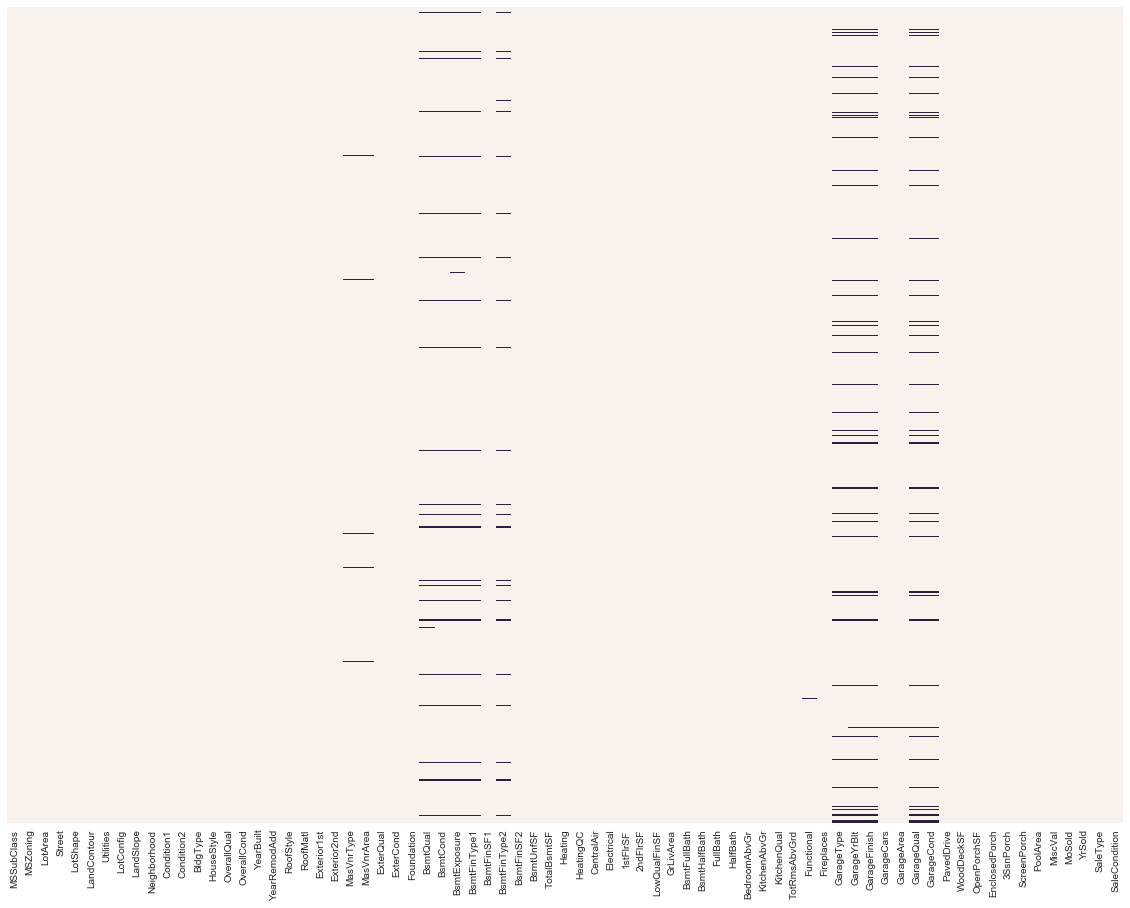

In [7]:
all_data.drop(['LotFrontage', 'Alley','FireplaceQu','PoolQC','Fence', 'MiscFeature'],axis =1, inplace = True )
plt.figure(figsize=(20,15))
sns.heatmap(all_data.isnull(),yticklabels= False, cbar= False)


In [8]:
# we will deal with the missing values later as we will determine which features to use after analysing the correlation

# 2. EDA


###  Now lets look how housing price is distributed

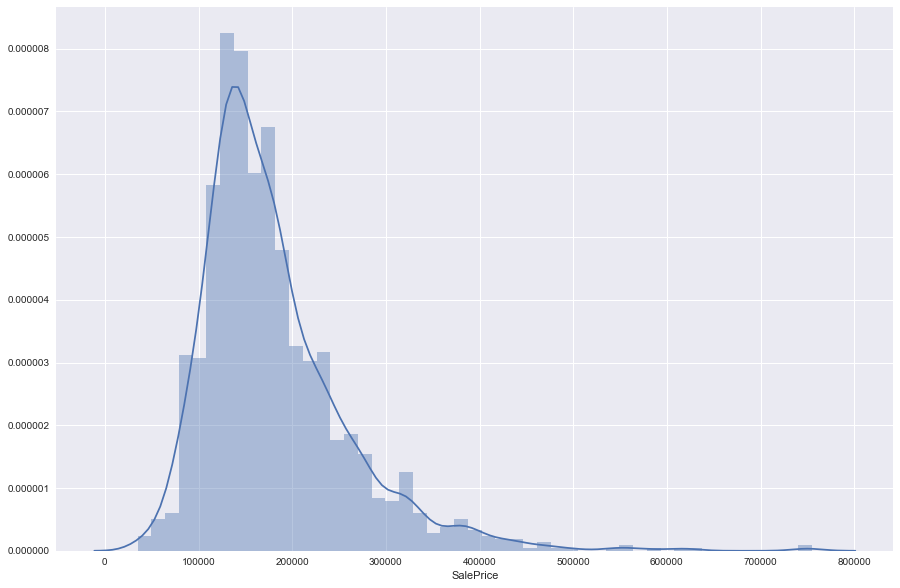

In [9]:
plt.figure(figsize=(15,10))
sns.distplot(train.SalePrice)
# we can see that the prices are skewed right 

We will want to obtain a normal distribution of the independent variable 
with log function 

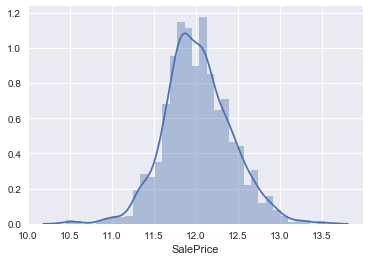

In [10]:
train["SalePrice"] = np.log1p(train["SalePrice"])
sns.distplot(train.SalePrice)

In [11]:
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 0.121347
Kurtosis: 0.809519


In [12]:
from scipy.stats import kurtosis
from scipy.stats import skew
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])



#### Why use logarithmic transformations of variables
- Logarithmically transforming variables in a regression model is a very common way to handle situations where a non-linear relationship exists between the independent and dependent variables
- Logarithmic transformations are also a convenient means of transforming a highly skewed variable into one that is more approximately normal.
- from http://kenbenoit.net/assets/courses/ME104/logmodels2.pdf

## Correlation 

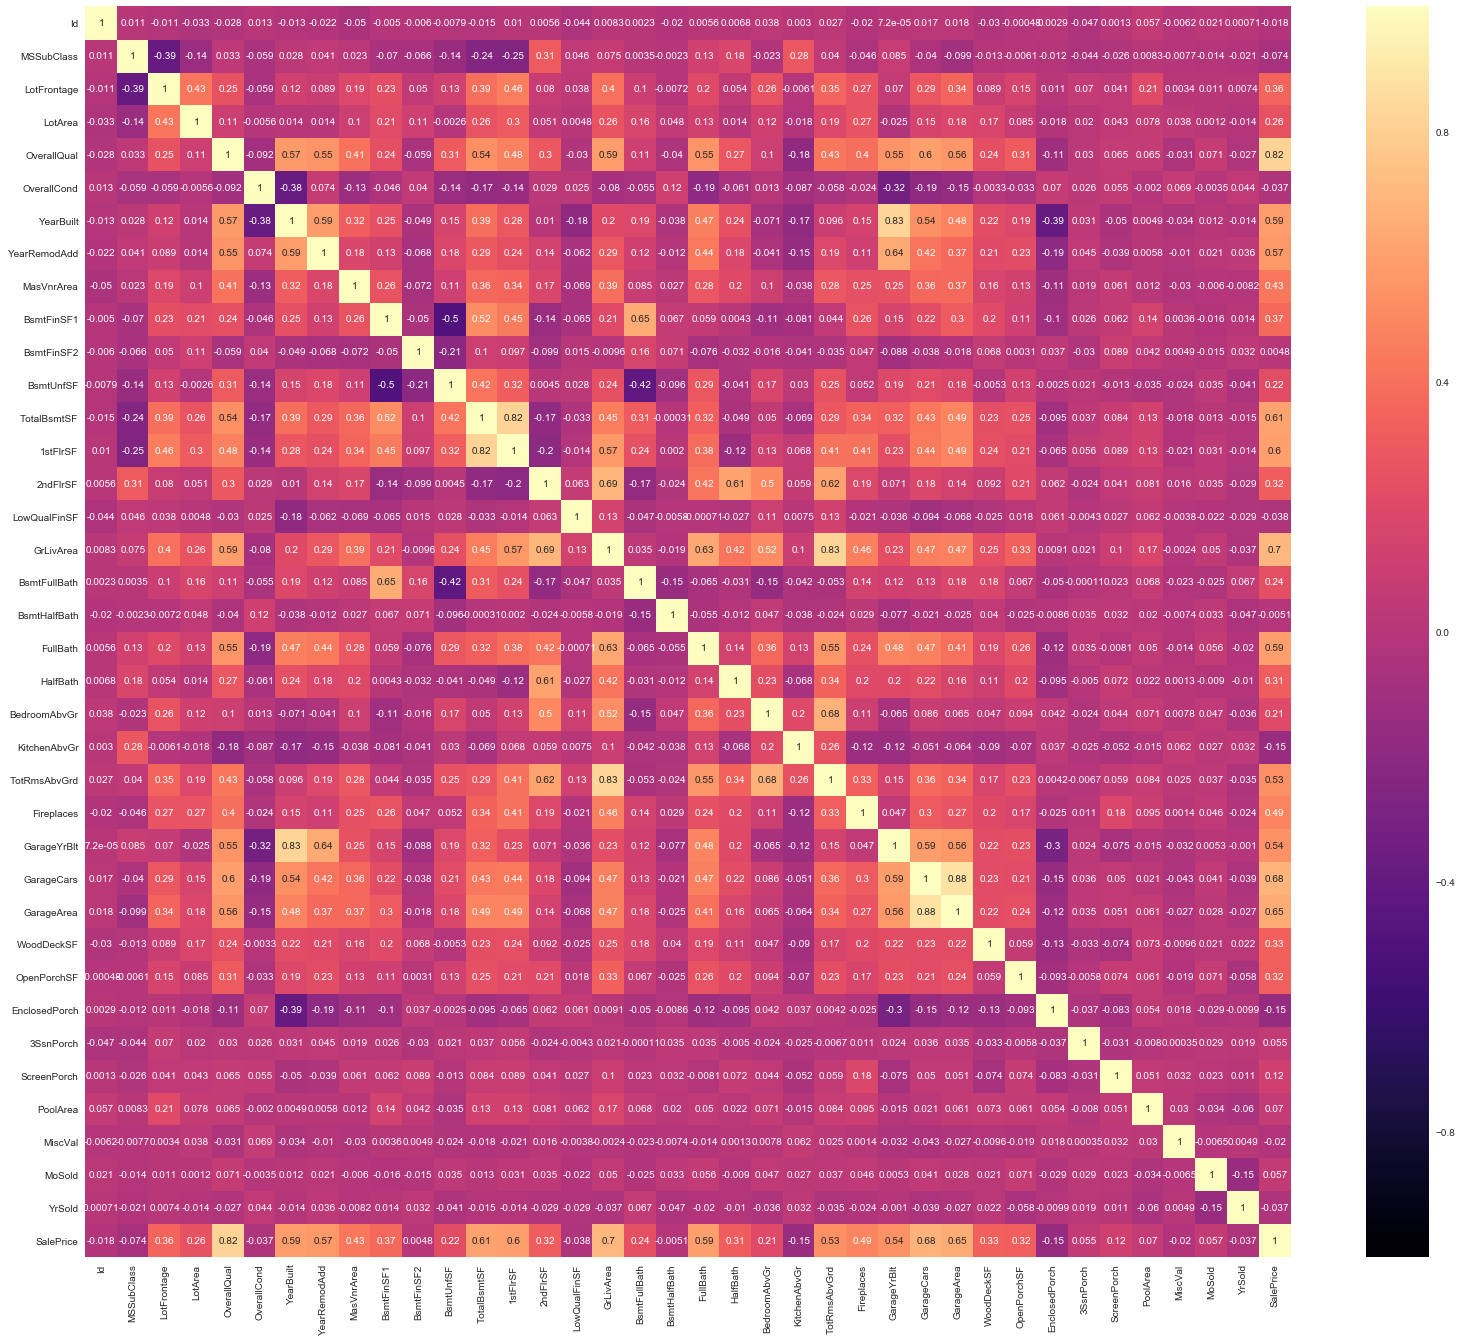

In [13]:
plt.figure(figsize=(27,23))
train_corrmatrix = train.corr()
sns.heatmap(train_corrmatrix , annot = True, cmap = 'magma')


From the heat map we can identify some collinearity between features -> will have to remove one of the features
- 1stFlrSF is highly correlated with TotalBsmtSF 
- GarageArea is highly correlated  with Garage Cars 
- GarageYrBlt is highly correlated with YearBuilt 
- GrLivingArea is highly correlated TotalRmsAbvGrd


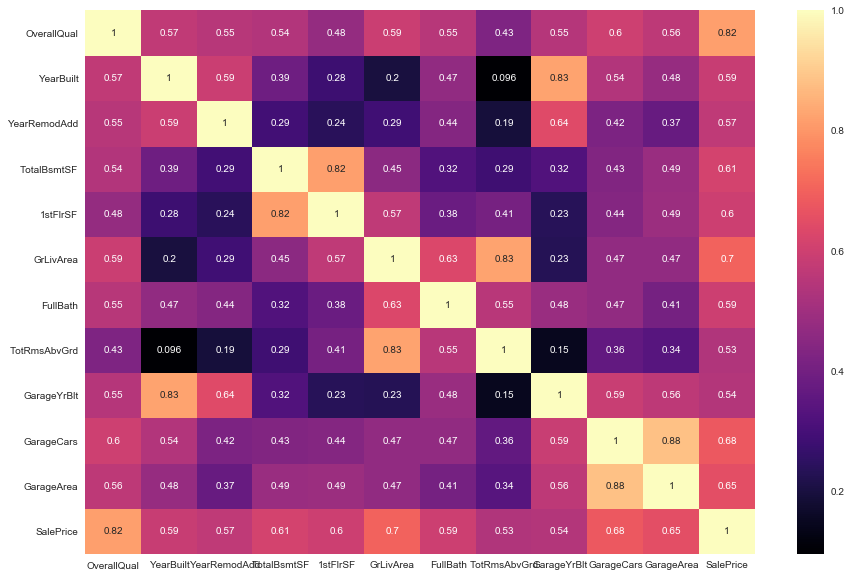

In [14]:
#Select the feature that have > 0.5 corr 
top_corr_features = train_corrmatrix .index[abs(train_corrmatrix ["SalePrice"])>0.5]
plt.figure(figsize=(15,10))
sns.heatmap(train[top_corr_features].corr(),annot =True, cmap = 'magma')


In [15]:
top_corr_features = train_corrmatrix .index[abs(train_corrmatrix ["SalePrice"])>0.5]
stronger_corr = top_corr_features[:-1].values #-1 because the last value is quality 
print('There is {} strong correlated values with sales price: \n{}'.format(len(stronger_corr),stronger_corr))
#it seems that the features are not very strongly correlated with quality

There is 11 strong correlated values with sales price: 
['OverallQual' 'YearBuilt' 'YearRemodAdd' 'TotalBsmtSF' '1stFlrSF'
 'GrLivArea' 'FullBath' 'TotRmsAbvGrd' 'GarageYrBlt' 'GarageCars'
 'GarageArea']


In [16]:
train[stronger_corr].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 11 columns):
OverallQual     1460 non-null int64
YearBuilt       1460 non-null int64
YearRemodAdd    1460 non-null int64
TotalBsmtSF     1460 non-null int64
1stFlrSF        1460 non-null int64
GrLivArea       1460 non-null int64
FullBath        1460 non-null int64
TotRmsAbvGrd    1460 non-null int64
GarageYrBlt     1379 non-null float64
GarageCars      1460 non-null int64
GarageArea      1460 non-null int64
dtypes: float64(1), int64(10)
memory usage: 125.5 KB


As we have discovered previously,
- 1stFlrSF is highly correlated with TotalBsmtSF 
- GarageArea is highly correlated  with Garage Cars 
- GarageYrBlt is highly correlated with YearBuilt 
- GrLivingArea is highly correlated TotalRmsAbvGrd

We need to remove features with collinearity -  GarageCars, GarageYrBlt, GrLivArea from the features selected

In [17]:
top_features = train[stronger_corr]
top_features.columns

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
       'GarageArea'],
      dtype='object')

## Remove features with collinearity 

In [18]:
selected_quali_feats= train[['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd','GarageArea']]
selected_quali_feats.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,GarageArea
0,7,2003,2003,856,856,2,8,548
1,6,1976,1976,1262,1262,2,6,460
2,7,2001,2002,920,920,2,6,608
3,7,1915,1970,756,961,1,7,642
4,8,2000,2000,1145,1145,2,9,836


# Train with Linear Regression Model 

In [19]:
#Import the necessary libraries 
from sklearn.linear_model import LinearRegression
from sklearn import metrics 
import statsmodels.formula.api as smf

In [20]:
X = selected_quali_feats
y = train.SalePrice

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [22]:
#train the test data with scikit learn
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Evaluating Coefficients

In [85]:
#SCIKITLEARN
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
print('Intercept:', lm.intercept_)
coeff_unlog =pd.DataFrame(data = np.expm1(lm.coef_), index =X.columns,columns = ['Coefficient unlog' ])
pd.concat([coeff_df,coeff_unlog], axis =1)
#No idea what i am doing here 

Intercept: 3.36096894579


,Coefficient,Coefficient unlog
OverallQual,0.110294,0.116606
YearBuilt,0.001659,0.001661
YearRemodAdd,0.002011,0.002013
TotalBsmtSF,0.000149,0.000149
1stFlrSF,0.000070,0.000070
FullBath,0.018505,0.018678
TotRmsAbvGrd,0.049200,0.050430
GarageArea,0.000295,0.000295


In [25]:
#STATS MODEL 
import statsmodels.api as sm
X_train = sm.add_constant(X_train) #as stats model does not take into account coefficients-> need to add a constant 
est = sm.OLS(y_train, X_train) #fit the model 
est2 = est.fit()
print(est2.summary())

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     594.2
Date:                Tue, 08 May 2018   Prob (F-statistic):               0.00
Time:                        12:01:50   Log-Likelihood:                 389.04
No. Observations:                1022   AIC:                            -760.1
Df Residuals:                    1013   BIC:                            -715.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.3610      0.679      4.948   

#### Findings: 
##### P value 
- Most features have small p value, except FullBath
- There is no association between FullBath and Sale Price
- Remove FullBath from the features 

Useful links: 
- https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression/34983005
- https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqhow-do-i-interpret-a-regression-model-when-some-variables-are-log-transformed/


## Predicting Test Data

In [26]:
predictions = lm.predict(X_test)

#### Create a scatterplot of the real test values versus the predicted values

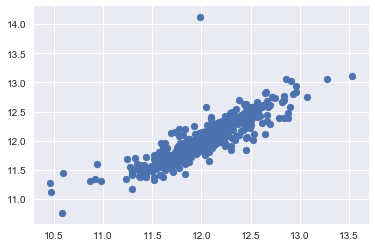

In [27]:
plt.scatter(y_test,predictions) 
#There is an outlier -> need to remove 

In [31]:
#There was a outlier in the prediction results, this part is to remove the outlier
#y_test.drop(1063, axis =0,inplace =True)
#predictions = np.delete(predictions, 163)
print(predictions.size)
print(y_test.size)

437
437


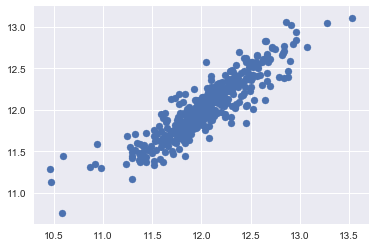

In [30]:
plt.scatter(y_test,predictions)

## Evaluting the Model

#### Let's evaluate our model performance by calculating the residual sum of squares and R squared

## MAE & RMSE

In [66]:
from math import exp, expm1
MAE = metrics.mean_absolute_error(y_test, predictions)
RMSE= np.sqrt(metrics.mean_squared_error(y_test, predictions))                                
print('MAE:',MAE)
print('RMSE:',RMSE)
print('Exp MAE:',exp(MAE))
print('Exp RMSE:',exp(RMSE))

MAE: 0.128632365477
RMSE: 0.179928424061
Exp MAE: 1.137271946872322
Exp RMSE: 1.1971316742317515


#### MAR VS RMSE
- RMSE has the benefit of penalizing large errors more so can be more appropriate in some cases
Useful links: https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d

## R square

In [35]:
from sklearn.metrics import r2_score 

In [36]:
r2_score(y_test, predictions)

0.80742727462384434

##### R-squared is between 0 and 1
- Definition: Higher values are better because it means that more variance is explained by the model.
- Findings: A high R squared, the model may be overfitted

## Distribution of residual

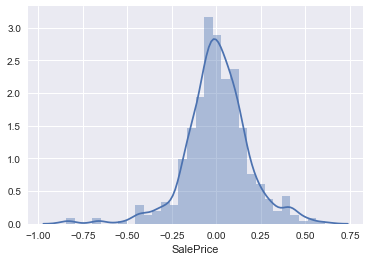

In [42]:
sns.distplot((y_test-predictions))

If the residual is normally distributed - the model is a good choice of model
- Is this consider normally distributed? It seems to be a bit skewed

## Possible Extension of the model: 
- Cross validation 
- Incorporate categorical features
- Lasso/ridge regression